# Check for spatial correlations in residuals of random k-fold models

In [85]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import xgboost as xgb
import gstools as gs
from matplotlib import pyplot as plt


from model_functions import select_variables
from model_functions import train_xgb_model
from model_functions import get_model_residuals
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction

In [13]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)

# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]

df_test = glacier_data_all[glacier_data_all['BREID'].isin(test_glaciers)]
# 54 has 37 points
# 703 has 13 points
# 1280 has 25 points
# 2478 has 22 points
# 2769 has 10 points
# 3127 has 60 points
# test has 323 points in total

df_train = glacier_data_all[~glacier_data_all['BREID'].isin(test_glaciers)]

# Run with different random seeds
rand_seed = 25

C:\Users\kasj\AppData\Local\Temp\ipykernel_14232\17134410.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [48]:
# Select features
base_cols = ['altitude','aspect','slope','altitude_climate','lat','lon']
temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

# Select features for training
df_train_X = select_variables(df_train, base_cols, temp_cols, prec_cols)

# Select labels for training
df_train_y = select_variables(df_train, label_cols)

X_train, y_train = df_train_X.values, df_train_y.values

# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

In [49]:
#joblib.dump(cv_grid, 'Models/Random_5fold/cv_random_5fold_temp_prec_seed25.pkl')
cv_grid = joblib.load('Models/Random_5fold/cv_random_5fold_temp_prec_seed25.pkl')

In [50]:
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [51]:
residuals = get_model_residuals(X_train, y_train, fitted_model, splits)

In [52]:
residuals.shape

(2809,)

In [53]:
print(X_train[0][4])
print(X_train[0][5])



68.34460666077922
17.86015112957877


## Estimate variogram of residuals


In [103]:
lon_list = []
lat_list = []
alt_list = []

for train_index, val_index in splits:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_ign, X_val = X_train[train_index], X_train[val_index]
    #X_train_ign, X_val_alt = X_train[train_index], X_train[val_index]
    #X_train_ign, X_val_lon = X_train[train_index], X_train[val_index]

    X_lat = X_val[:,4]
    X_lon = X_val[:,5]
    X_alt = X_val[:,0]
    
    lat_list.extend(X_lat)
    lon_list.extend(X_lon)
    alt_list.extend(X_alt)
        
# Arrays of predictions and observations for each fold
lat_all = np.hstack([*lat_list])
lon_all = np.hstack([*lon_list])
alt_all = np.hstack([*alt_list])

In [104]:
alt_all

array([ 996. ,  988. ,  981. , ..., 1154. , 1145. , 1513.3])

In [81]:
#x = data_job['lon'].values
#y = data_job['lat'].values
#mb = data_job['balance_netto'].values
coords = np.stack((lon_all,lat_all), axis=1)

# Use only data that is not nan
#coords=coords[~np.isnan(mb)]
#mb_clean=mb[~np.isnan(mb)]

In [80]:
# estimate the variogram of the field
bin_center, gamma = gs.vario_estimate((lon_all, lat_all), residuals, latlon=True, geo_scale=gs.KM_SCALE)

print('bin_center: ', bin_center)
print('gamma: ', gamma)
print("estimated bin number:", len(bin_center))
print("maximal bin distance:", max(bin_center))

bin_center:  [ 11.46481707  34.39445122  57.32408537  80.25371952 103.18335367
 126.11298782 149.04262197 171.97225612 194.90189027 217.83152441
 240.76115856 263.69079271 286.62042686 309.55006101 332.47969516
 355.40932931 378.33896346 401.26859761 424.19823175 447.1278659
 470.05750005 492.9871342  515.91676835 538.8464025 ]
gamma:  [0.38179609 0.33532766 0.37151586 0.48654157 0.46982091 0.40008305
 0.32575189 0.40809838 0.39684302 0.34315392 0.34864048 0.41644276
 0.40233528 0.40563555 0.25891225 0.         0.         0.
 0.         0.53833652 0.17281399 0.56324893 0.24386688 0.        ]
estimated bin number: 24
maximal bin distance: 538.8464024985662


In [83]:
models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores = {}

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\gstools\covmodel\plot.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


JBessel(dim=2, var=2.17e-16, len_scale=3.03e+03, nugget=0.305, nu=50.0)


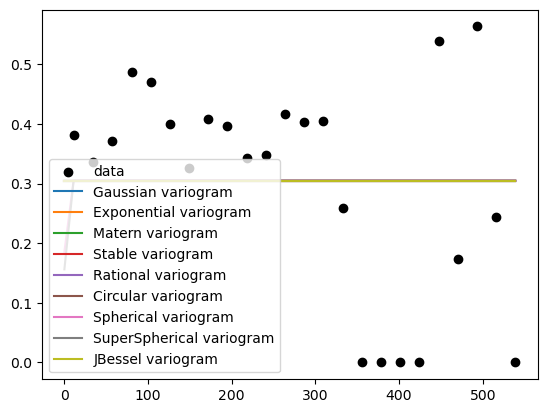

In [84]:
# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
    fit_model.plot(x_max=max(bin_center), ax=ax)
    scores[model] = r2
print(fit_model)

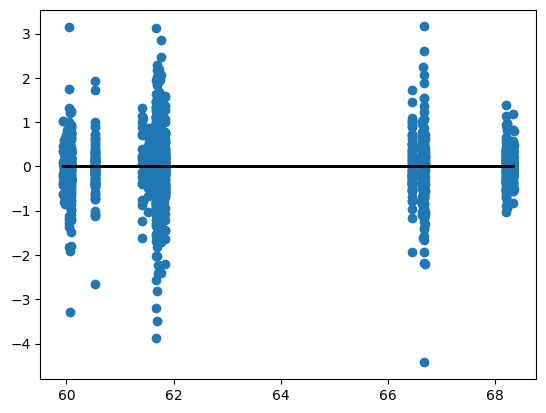

In [91]:
plt.scatter(lat_all, residuals)
plt.plot(lat_all, np.zeros(lat_all.shape), color='k')

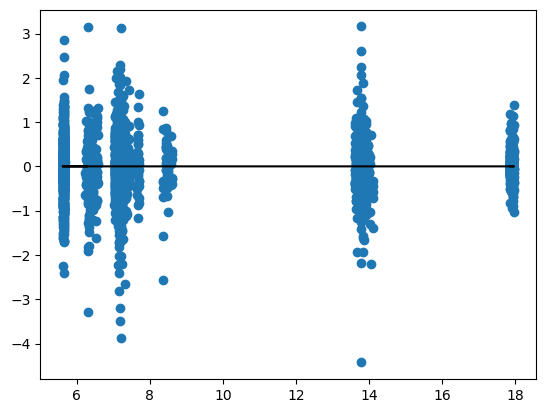

In [92]:
plt.scatter(lon_all, residuals)
plt.plot(lon_all, np.zeros(lon_all.shape), color='k')

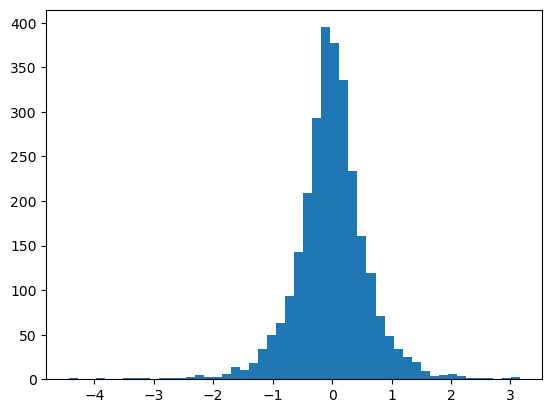

In [102]:
plt.hist(residuals, bins=50);

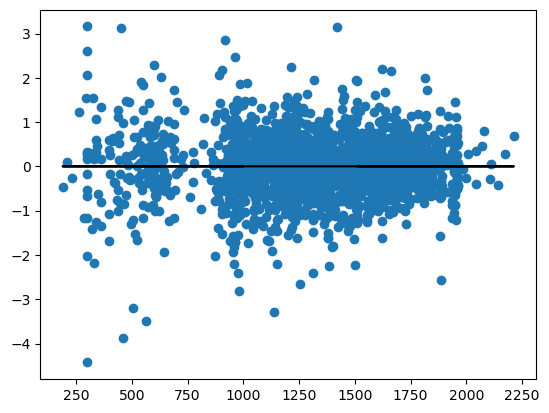

In [107]:
plt.scatter(alt_all, residuals)
plt.plot(alt_all, np.zeros(lon_all.shape), color='k')